<a href="https://colab.research.google.com/github/ivkarla/connectivity_change/blob/main/notebooks/patients_score_S.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook makes boxplots of resection overlap (S) scores across patients. Patient with good and poor outcomes are compared using the Mann–Whitney U two-sided test.

The function below modifies connectivity measure labels for readibility.

In [27]:
import re

# Dictionary for band symbol substitutions
band_subs = {
    "1,4": "δ",
    "4,8": "ϴ",
    "8,12": "α",
    "13,30": "β",
    "30,70": "low γ",
    "70,150": "high γ"
}

# Dictionary for connectivity method substitutions
# cm_subs = {
#     "SC_R": "Real spectral coherence",
#     "SC_I": "Imaginary spectral coherence",
#     "PLV": "Phase-locking value",
#     "PLI": "Phase lag index",
#     "CC": "Cross-correlation",
#     "PAC": "PAC",
#     "PEC": "PEC"
# }
cm_subs = {
    "SC_R": "SCR",
    "SC_I": "SCI",
    "PLV": "PLV",
    "PLI": "PLI",
    "CC": "CC",
    "PAC": "PAC",
    "PEC": "PEC"
}

# Function to replace bands with their corresponding symbols
def substitute_bands(s):
    # Find all occurrences of band ranges in the format "(a,b)"
    bands = re.findall(r'\(\d+,\d+\)', s)

    # Substitute each band range with its corresponding symbol
    for band in bands:
        band_range = band[1:-1]  # Remove parentheses
        if band_range in band_subs:
            s = s.replace(band, f" ({band_subs[band_range]})")

    return s

# Function to replace connectivity methods with their corresponding names
def substitute_cm(s):
    # Find all occurrences of connectivity method prefixes
    for cm in cm_subs:
        s = re.sub(r'\b' + cm + r'\b', cm_subs[cm], s)

    return s

# Test
input_str = "CC(30,70), SC_R(70,150)"
output_str = substitute_cm(input_str)
output_str = substitute_bands(output_str)

print(output_str)

CC (low γ), SCR (high γ)


Import libraries and define path to results.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

!pip install statannot
from statannot import add_stat_annotation
from scipy.stats import mannwhitneyu

from google.colab import drive
drive.mount('/content/gdrive')
main_folder = "/content/gdrive/Shared drives/A&K/data/"

source = main_folder + "results.xlsx"
source_nn = main_folder + "results-nn.xlsx"


Mounted at /content/gdrive


Define which connectivity measures we are interested in. The S scores for the corresponding networks will be plotted. We selected the measures that provded the best outcome prediction ROC-AUC.

In [28]:
# Single connectivity measures
methods = {
    "NN": ["SC_R(70,150)"],
    "N60S": ["CC(30,70)"],
    "NS": ["SC_R(4,8)", "SC_R(30,70)"],
    "NE": ["PLV(4,8)", "PLV(8,12)", "PLV(13,30)"]
}

# Best combinations of connectivity measures
methods_comb = {
    "NN": ["PEC", "CC(30,70)", "SC_R(70,150)", "SC_I(70,150)"],
    "N60S": ["SC_I(1,4)", "SC_I(4,8)", "SC_R(13,30)", "SC_R(70,150)", "SC_R(30,70)"],
    "NS": ["SC_R(4,8)", "SC_R(30,70)", "SC_R(8,12)", "CC(30,70)"],
    "NE": ["PLV(4,8)", "PLV(8,12)", "PAC"]
}

Generate plots:

In [5]:
# Function for generating box pairs that will be compared using a statistical test
def generate_box_pairs(t):
    if t in methods:
        return [(("{}".format(method), 1), ("{}".format(method), 0)) for method in methods[t]]
    else:
        return []

Plot the resection overlap score boxplots for single CMs.

Performing MannWhitneyU Two-sided statistical test for equal variances on pair: (('SC_R(70,150)', 1), ('SC_R(70,150)', 0)) stat=7.90e+01 p-value=2.57e-02
pvalues: [0.025748080821108063]


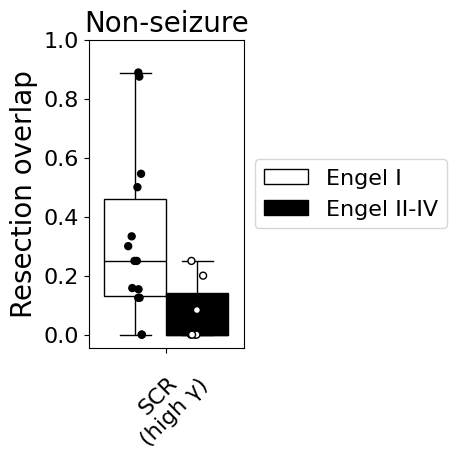

Performing MannWhitneyU Two-sided statistical test for equal variances on pair: (('CC(30,70)', 1), ('CC(30,70)', 0)) stat=7.20e+01 p-value=3.67e-02
pvalues: [0.036655033072355576]


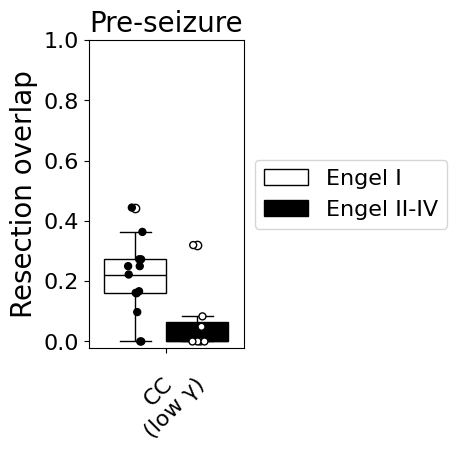

Performing MannWhitneyU Two-sided statistical test for equal variances on pair: (('SC_R(4,8)', 1), ('SC_R(4,8)', 0)) stat=7.95e+01 p-value=2.26e-02
Performing MannWhitneyU Two-sided statistical test for equal variances on pair: (('SC_R(30,70)', 1), ('SC_R(30,70)', 0)) stat=7.95e+01 p-value=2.33e-02
pvalues: [0.022563368723744814, 0.023342202012890816]


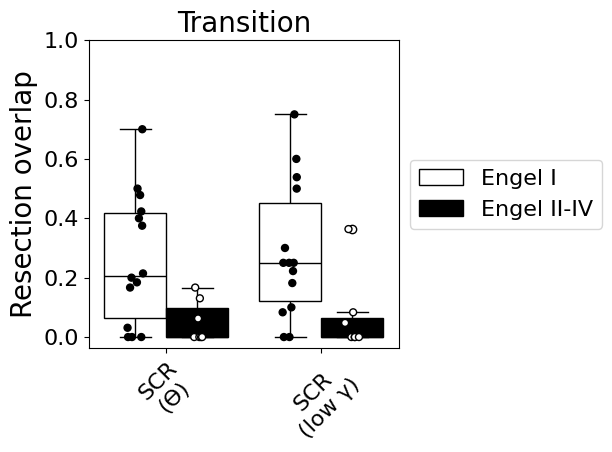

Performing MannWhitneyU Two-sided statistical test for equal variances on pair: (('PLV(4,8)', 1), ('PLV(4,8)', 0)) stat=7.60e+01 p-value=4.65e-02
Performing MannWhitneyU Two-sided statistical test for equal variances on pair: (('PLV(8,12)', 1), ('PLV(8,12)', 0)) stat=7.60e+01 p-value=4.65e-02
Performing MannWhitneyU Two-sided statistical test for equal variances on pair: (('PLV(13,30)', 1), ('PLV(13,30)', 0)) stat=7.60e+01 p-value=4.65e-02
pvalues: [0.046520042864648344, 0.046520042864648344, 0.046520042864648344]


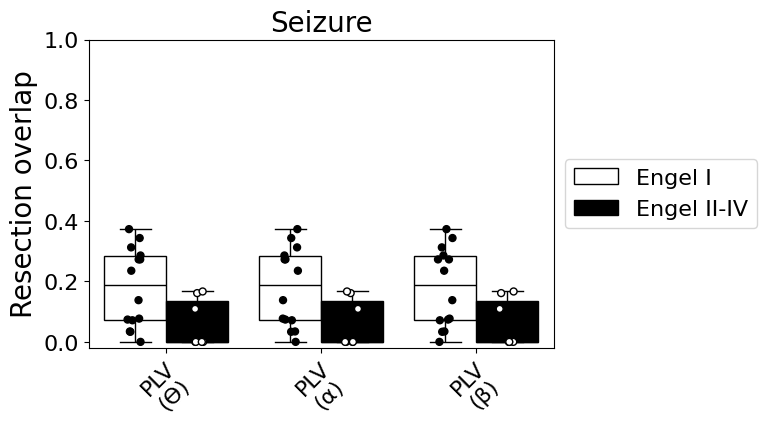

In [ ]:
data = None

to_plot, box_pairs = [], []
for t in methods.keys():

    woi_str = ''
    if t=="NS": woi_str = "Transition"
    elif t=="N60S": woi_str = "Pre-seizure"
    elif t=="NE": woi_str = "Seizure"
    elif t=="NN": woi_str = "Non-seizure"

    if t == "NN": data = pd.read_excel(source_nn)
    else: data = pd.read_excel(source)

    group_tframe = data.groupby(["time_frame"]).get_group((t))
    group_method = group_tframe.groupby(["method"])

    to_plot = pd.concat([group_method.get_group(method) for method in methods[t]]) if len(methods[t])>1 else group_method.get_group(methods[t][0])

    box_pairs = generate_box_pairs(t)

    test_short_name = 'MannWhitneyU Two-sided'

    pvalues = []

    for pair in box_pairs:

        data1 = to_plot.groupby("method").get_group(pair[0][0]).groupby("outcome")["score1"].get_group(pair[0][1])
        data2 = to_plot.groupby("method").get_group(pair[1][0]).groupby("outcome")["score1"].get_group(pair[1][1])

        stat, p = mannwhitneyu(data1, data2, alternative="two-sided")
        print("Performing %s statistical test for equal variances on pair:"%test_short_name, pair, "stat={:.2e} p-value={:.2e}".format(stat, p))
        pvalues.append(p)

    print("pvalues:", pvalues)

    palette_box = {1:"white", 0:"black"}
    palette_strip = {0:"white", 1:"black"}

    plt.figure(figsize=(2*len(methods[t]),4))

    bp = sns.boxplot(y="score1", x="method", data=to_plot, palette=palette_box, hue="outcome", hue_order=[1,0])
    bp = sns.stripplot(y="score1", x="method", data=to_plot, jitter=True, dodge=True, marker="o", ax=bp, hue="outcome", hue_order=[1,0], palette=palette_strip, linewidth=1, edgecolor="black")

    handles, labels = bp.get_legend_handles_labels()
    plt.legend(handles[0:2], ["Engel I", "Engel II-IV"], fontsize=16, loc='center left', bbox_to_anchor=(1, 0.5))

    plt.title("%s"%woi_str, size=20)
    plt.ylim(None,1.0)
    plt.yticks(fontsize=16)
    plt.ylabel("Resection overlap", fontsize=20)
    plt.xticks(list(range(len(methods[t]))), [substitute_cm(substitute_bands(m)) for m in methods[t]], fontsize=16, rotation=45)
    plt.xlabel('')
    # add_stat_annotation(bp, data=to_plot, y="score1", x="method", hue="outcome",
    #                             box_pairs=box_pairs, perform_stat_test=False, pvalues=pvalues, test_short_name=test_short_name,text_format='star', fontsize="large", linewidth=2, loc='inside', verbose=2)

    plt.show()
    # plt.savefig("D:/%s.png"%t)
    plt.close()

Plot the average resection overlap score for the best combination of scores per time frame.

stat=8.60e+01 p-value=4.23e-03
p-value: 0.004231166150670795


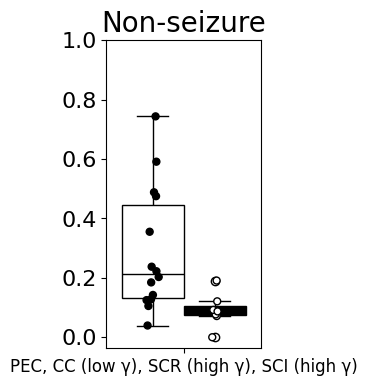

stat=8.45e+01 p-value=9.00e-03
p-value: 0.009001082260185627


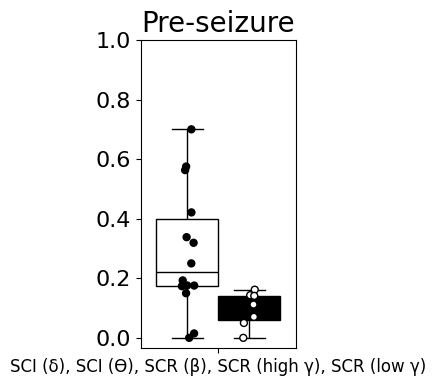

stat=8.85e+01 p-value=3.61e-03
p-value: 0.0036081770190667314


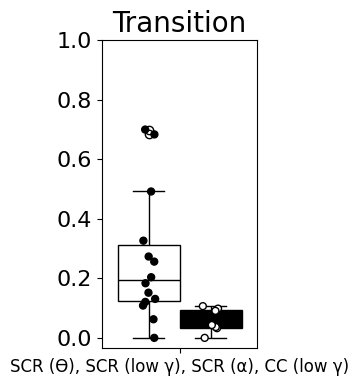

stat=8.10e+01 p-value=1.87e-02
p-value: 0.018694077884774955


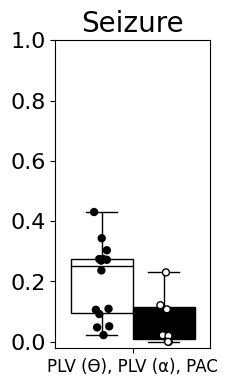

In [32]:
data = None

to_plot, box_pairs = [], []
for t in methods_comb.keys():

    woi_str = ''
    if t=="NS": woi_str = "Transition"
    elif t=="N60S": woi_str = "Pre-seizure"
    elif t=="NE": woi_str = "Seizure"
    elif t=="NN": woi_str = "Non-seizure"

    if t == "NN": data = pd.read_excel(source_nn)
    else: data = pd.read_excel(source)

    group_tframe = data.groupby(["time_frame"]).get_group((t))

    # Filter data for methods in methods_comb[t] and calculate average score1 for each subject
    av_score1 = group_tframe[group_tframe['method'].isin(methods_comb[t])].groupby('subject')['score1'].mean().reset_index(name='average_score1')
    # Add method column with the list of methods
    av_score1['method'] = ', '.join(methods_comb[t])

    # Merge with original DataFrame to retain 'outcome' information
    to_plot = pd.merge(av_score1, group_tframe[['subject', 'outcome']].drop_duplicates(), on='subject', how='left')


    data1 = to_plot.groupby("outcome")["average_score1"].get_group(1)
    data2 = to_plot.groupby("outcome")["average_score1"].get_group(0)

    stat, p = mannwhitneyu(data1, data2, alternative="two-sided")
    print("stat={:.2e} p-value={:.2e}".format(stat, p))

    print("p-value:", p)

    palette_box = {1:"white", 0:"black"}
    palette_strip = {0:"white", 1:"black"}

    plt.figure(figsize=(2,4))

    bp = sns.boxplot(y="average_score1", x="method", data=to_plot, palette=palette_box, hue="outcome", hue_order=[1,0], legend=False)
    bp = sns.stripplot(y="average_score1", x="method", data=to_plot, jitter=True, dodge=True, marker="o", ax=bp, hue="outcome", hue_order=[1,0], palette=palette_strip, linewidth=1, edgecolor="black", legend=False)

    # handles, labels = bp.get_legend_handles_labels()
    # plt.legend(handles[0:2], ["Engel I", "Engel II-IV"], fontsize=16, loc='center left', bbox_to_anchor=(1, 0.5))

    plt.title("%s"%woi_str, size=20)
    plt.ylim(None,1.0)
    plt.yticks(fontsize=16)
    # plt.ylabel("Resection overlap", fontsize=20)
    plt.ylabel('')
    plt.xticks(ticks=[0], labels=[substitute_cm(substitute_bands(', '.join(methods_comb[t])))], fontsize=12)
    plt.xlabel('')
    # add_stat_annotation(bp, data=to_plot, y="average_score1", x="method", hue="outcome",
    #                             box_pairs=box_pairs, perform_stat_test=False, pvalues=pvalues, test_short_name=test_short_name,text_format='star', fontsize="large", linewidth=2, loc='inside', verbose=2)

    plt.show()
    # plt.savefig("D:/%s.png"%t)
    plt.close()